In [2]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.9 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=8c08081ed990f532d3226d6785092abb89266211cfa97a9468c3112641c658af
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=903d54d2a94f7dd558125b5d15e83e48fac5021eea90f5e7f5ce8ad8f2f4ae79
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

In [3]:
!pip install torchinfo

In [5]:
import os
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
import logging
from pathlib import Path
import shutil
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.auto import tqdm

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss

# Constants
IMAGE_SIZE = (224, 224)
SUPPORTED_FORMATS = ['.jpg', '.jpeg', '.png']

In [6]:
def compute_accuracy_loss(model, data_loader, criterion, device="cuda"):
    accuracy = 0
    loss = 0
    with torch.no_grad():

        for i, (image, mask) in enumerate(data_loader):

            image = image.float().to(device)
            mask = mask.float().to(device)

            mask_pred = model(image)

            loss_batch = criterion(mask_pred,mask)
            loss += loss_batch.item()

            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask.int(),
                                             threshold=0.5,
                                             mode='binary')
            accuracy_batch = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()
            accuracy += accuracy_batch
    return accuracy / len(data_loader), loss / len(data_loader)
    


def compute_accuracy(model, data_loader, device="cuda"):
    accuracy = 0
    with torch.no_grad():

        for i, (image, mask) in enumerate(data_loader):

            image = image.float().to(device)
            mask = mask.to(device)

            mask_pred = model(image)
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask,
                                             threshold=0.5,
                                             mode='binary')
            accuracy_batch = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()

            accuracy += accuracy_batch
    return accuracy / len(data_loader)
    
    
def compute_loss(model, data_loader, criterion, device="cuda"):

    loss = 0
    with torch.no_grad():
        for i, (image, mask) in enumerate(data_loader):
            image = image.float().to(device)
            mask = mask.float().to(device)

            mask_pred = model(image)
            loss_batch = criterion(mask_pred,mask)

            loss += loss_batch.item()

    return loss / len(data_loader)

In [7]:
def check_metrics(dataloader, model, device="cuda"):
    accuracy_list = []
    jaccard_list = []
    dice_list = []
    pix_acc_list = []
    specificity_list = []
    sensitivity_list = []

    with torch.no_grad():
        for image, mask in dataloader:
            image = image.to(device).type(torch.float32)
            mask = mask.to(device)
            pred = model(image)
            pred = (pred > 0.5).int()

            tp, fp, fn, tn = smp.metrics.get_stats(pred, mask,
                                             threshold=0.5,
                                             mode='binary')
            intersection = torch.logical_and(pred, mask).sum().detach()
            union = torch.logical_or(pred, mask).sum().detach()

            sensitivity = smp.metrics.functional.sensitivity(tp, fp, fn, tn, reduction="micro")
            specificity = smp.metrics.functional.specificity(tp, fp, fn, tn, reduction="micro")
            sensitivity_list.append(sensitivity)
            specificity_list.append(specificity)


            accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
            accuracy_list.append(accuracy)

            jaccard_score = intersection / union
            jaccard_list.append(jaccard_score)

            dice_score = (2.0 * intersection) / (pred.sum().detach() + mask.sum().detach())
            dice_list.append(dice_score)
            

    sensitivity = torch.mean(torch.stack(sensitivity_list)).item()
    specificity = torch.mean(torch.stack(specificity_list)).item()
    print(f"Sensitivity: {sensitivity:.6f}")
    print(f"Specificity: {specificity:.6f}")

    pix_acc = torch.mean(torch.stack(accuracy_list)).item()
    print(f"Pixel Accuracy: {pix_acc:.6f}")

    jaccard = torch.mean(torch.stack(jaccard_list)).item()
    print(f"Jaccard Score: {jaccard:.6f}")

    dice = torch.mean(torch.stack(dice_list)).item()
    print(f"Dice Score: {dice:.6f}")

    return sensitivity, specificity, pix_acc, jaccard, dice

In [8]:
def plot_loss_accuracy(train_loss_list, val_loss_list, val_acc_list):

    num_epochs = len(train_loss_list)
    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(np.arange(1, num_epochs+1), train_loss_list, color="green", label='Train Loss')
    ax1.plot(np.arange(1, num_epochs+1), val_loss_list, color="red", label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.legend()

    ax2.plot(np.arange(1, num_epochs+1), val_acc_list, color="blue", label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()
    

def plot_img_mask_pred(dataset, index=None, plot_pred=False, model=None, device = "cuda"):
    if not index:
        index = random.randint(0, len(dataset) - 1)

    image = dataset[index][0].permute(1,2,0)
    mask = dataset[index][1].permute(1,2,0)

    if plot_pred:
        img_to_pred = dataset[index][0].unsqueeze(0).type(torch.float32).to(device)
        pred = model(img_to_pred)
        pred = pred.squeeze(0).cpu().detach().permute(1,2,0)
        pred[pred < 0]=0
        pred[pred > 0]=1


        # Plot the image
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Image")

        # Plot the mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")

        # Plot the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap='gray')
        plt.title("Prediction")

        # Show the plots
        plt.tight_layout()
        plt.show()

    else:
        # Plot the image
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Image")

        # Plot the mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")

        # Show the plots
        plt.tight_layout()
        plt.show()

In [9]:
def train_model(model, num_epochs, train_loader, valid_loader, criterion,
                optimizer, device, scheduler=None, scheduler_on='valid_loss'): # valid_loss or train_loss

    train_loss_list, valid_loss_list, valid_acc_list = [], [],  []

    for epoch in tqdm(range(num_epochs)):

        batch_loss_list = []
        model.train()
        for batch_idx, (image, mask) in enumerate(tqdm(train_loader)):


            image = image.float().to(device)
            mask = mask.float().to(device)

            # ## FORWARD AND BACK PROP
            mask_pred = model(image)
            loss = criterion(mask_pred,mask)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            batch_loss_list.append(loss.item())

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_loss =  sum(batch_loss_list) / len(batch_loss_list)
            valid_acc, valid_loss = compute_accuracy_loss(model, valid_loader, criterion, device=device)
            print(f'Epoch: {epoch+1:02d}/{num_epochs:02d} '
                  f'| Train Loss: {train_loss :.4f} '
                  f'| Validation Loss: {valid_loss :.4f} '
                  f'| Validation Accuracy: {valid_acc*100 :.1f}%')
            train_loss_list.append(train_loss)
            valid_loss_list.append(valid_loss)
            valid_acc_list.append(valid_acc)

        if scheduler is not None:

            if scheduler_on == 'valid_loss':
                scheduler.step(valid_loss_list[-1])
            elif scheduler_on == 'train_loss':
                scheduler.step(train_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')

    return train_loss_list, valid_loss_list, valid_acc_list

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate =5e-4
batch_size = 16
epochs = 50
size =(128,128)

In [15]:
device

device(type='cuda')

In [10]:
class ImagePreprocessor:
    """Skin Cancer Image preprocessing pipeline"""
    
    @staticmethod
    def hair_remove(image):
        """Remove hair from skin images"""
        try:
            grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
            blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
            _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
            final_image = cv2.inpaint(image, threshold, 1, cv2.INPAINT_TELEA)
            return final_image
        except Exception as e:
            print(f"Error in hair removal: {str(e)}")
            return image

    @staticmethod
    def deblur_image(image):
        """Deblur image using Wiener deconvolution"""
        psf = np.ones((5, 5)) / 25
        deblurred = np.zeros_like(image)
        for i in range(3):
            deblurred[:,:,i] = cv2.filter2D(image[:,:,i], -1, psf)
        return np.uint8(np.clip(deblurred, 0, 255))

    @staticmethod
    def sharpen_image(image):
        """Sharpen image using unsharp masking"""
        gaussian = cv2.GaussianBlur(image, (0, 0), 2.0)
        return cv2.addWeighted(image, 1.5, gaussian, -0.5, 0)

In [12]:
def preprocess_image(image):
    """Apply all preprocessing steps to an image"""
    preprocessor = ImagePreprocessor()
    
    image = preprocessor.hair_remove(image)
    image = preprocessor.sharpen_image(image)
    
    return image


def create_directory_structure(base_path):
    """Create the new directory structure"""
    base_path = Path(base_path)
    base_path.mkdir(parents=True, exist_ok=True)

In [18]:
def process_and_organize_dataset(source_path, destination_path):
    """Process images and organize them into the new structure"""
    source_path = Path(source_path)
    destination_path = Path(destination_path)
    
    # Create new directory structure
    create_directory_structure(destination_path)
    
    # Process each image in the source folder
    for img_file in tqdm([f for ext in SUPPORTED_FORMATS for f in source_path.glob(f'*{ext}')]):
        img = cv2.imread(str(img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
        # Apply preprocessing
        processed_img = preprocess_image(img.copy())
                
        # Generate filename without extension
        filename = img_file.stem
                
        # Save original preprocessed image
        original_path = destination_path / f"{filename}.jpg"
        cv2.imwrite(str(original_path), cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))

In [19]:
source_path = "/kaggle/input/isic-2016-original-dataset/isic 2016/ISBI2016_ISIC_Part1_Training_Data"
destination_path = "/kaggle/working/image_segmentation_data/train"
process_and_organize_dataset(source_path, destination_path)

  0%|          | 0/900 [00:00<?, ?it/s]

In [20]:
source_path = "/kaggle/input/isic-2016-original-dataset/isic 2016/ISBI2016_ISIC_Part1_Test_Data"
destination_path = "/kaggle/working/image_segmentation_data/test"
process_and_organize_dataset(source_path, destination_path)

  0%|          | 0/379 [00:00<?, ?it/s]

In [21]:
# Define the subdirectories for images and ground truth
train_image_dir = "/kaggle/working/image_segmentation_data/train"
train_gt_dir = "/kaggle/input/isic-2016-original-dataset/isic 2016/ISBI2016_ISIC_Part1_Training_GroundTruth"

test_image_dir = "/kaggle/working/image_segmentation_data/test"
test_gt_dir = "/kaggle/input/isic-2016-original-dataset/isic 2016/ISBI2016_ISIC_Part1_Test_GroundTruth"


# Get paths to the images and ground truth images
train_image_paths = sorted([os.path.join(train_image_dir, fname)
                      for fname in os.listdir(train_image_dir)
                      if fname.endswith(".jpg")])
train_gt_paths = sorted([os.path.join(train_gt_dir, fname)
                    for fname in os.listdir(train_gt_dir)
                    if fname.endswith(".png")])

test_image_paths = sorted([os.path.join(test_image_dir, fname)
                      for fname in os.listdir(test_image_dir)
                      if fname.endswith(".jpg")])
test_gt_paths = sorted([os.path.join(test_gt_dir, fname)
                    for fname in os.listdir(test_gt_dir)
                    if fname.endswith(".png")])

# Check if dimensions are equal
print("Number of samples in the train image folder:", len(train_image_paths))
print("Number of samples in the train mask folder:", len(train_gt_paths))
print("Number of samples in the test image folder:", len(test_image_paths))
print("Number of samples in the test mask folder:", len(test_gt_paths))

Number of samples in the train image folder: 900
Number of samples in the train mask folder: 900
Number of samples in the test image folder: 379
Number of samples in the test mask folder: 379


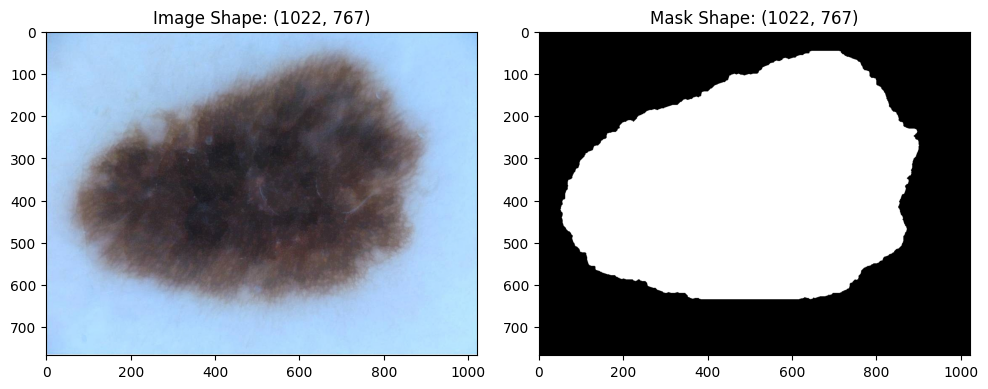

In [22]:
# Define the paths to your image and segmentation mask
image_path = train_image_paths[0]
mask_path = train_gt_paths[0]

# Open the image and mask using Pillow
image = Image.open(image_path)
mask = Image.open(mask_path)

# Get the dimensions (shape) of the image and mask
image_shape = image.size  # Returns (width, height)
mask_shape = mask.size    # Returns (width, height)

# Convert the image and mask to NumPy arrays for visualization
image_array = plt.imread(image_path)
mask_array = plt.imread(mask_path)

# Plot the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_array)
plt.title(f"Image Shape: {image_shape}")

# Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(mask_array, cmap='gray')  # Assuming the mask is grayscale
plt.title(f"Mask Shape: {mask_shape}")

# Show the plots
plt.tight_layout()
plt.show()

In [23]:
random_seed = 142
# Split your data into training, validation, and test sets
image_paths_train, image_paths_val, mask_paths_train, mask_paths_val = train_test_split(train_image_paths, train_gt_paths, test_size=0.15, random_state=random_seed)

In [24]:
class LesionSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        mask_name = self.mask_paths[idx]

        img = Image.open(img_name)
        mask = Image.open(mask_name)

        img = np.array(img)
        mask = np.array(mask)
        mask[mask==255.0] = 1.0

        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation["image"]
            mask = augmentation["mask"]
            mask = torch.unsqueeze(mask,0)
        return img,mask

In [25]:
train_transform = A.Compose([A.Resize(size[0],size[1]),
                             A.Rotate(limit=15,p=0.1),
                             A.HorizontalFlip(p=0.5),
                             A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                             ToTensorV2()])

val_transform = A.Compose([A.Resize(size[0],size[1]),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

In [26]:
train_dataset =  LesionSegmentationDataset(image_paths_train, mask_paths_train, transform = train_transform)
val_dataset = LesionSegmentationDataset(image_paths_val, mask_paths_val, transform = val_transform)
# test_dataset = LesionSegmentationDataset(test_image_paths, test_gt_paths)

In [27]:
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
# test_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=False)

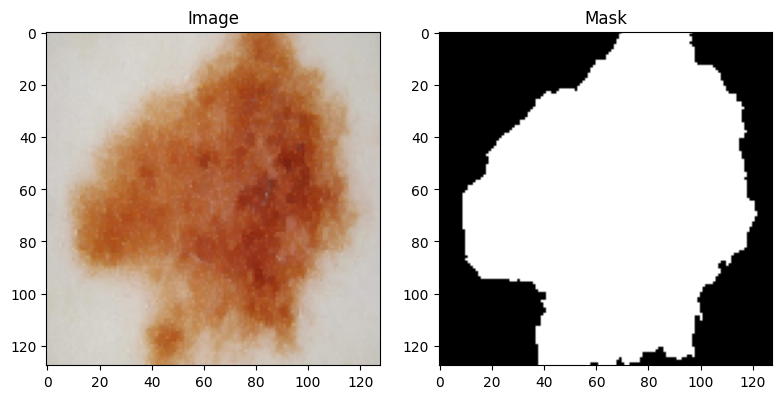

In [28]:
plot_img_mask_pred(train_dataset)

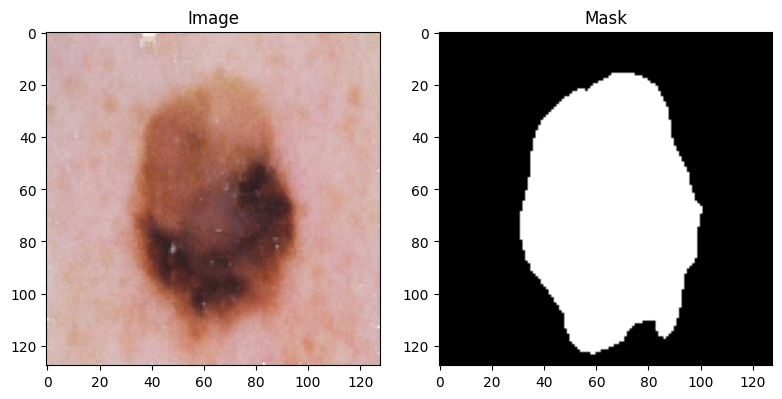

In [29]:
plot_img_mask_pred(val_dataset)

In [31]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3,stride=1,padding=1)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3,stride=1,padding=1)

    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x)))).to(device)

In [32]:
class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

In [33]:
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs  = chs
        self.upconvs  = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x  = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [35]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1):
        super().__init__()
        self.encoder = Encoder(enc_chs)
        self.decoder  = Decoder(dec_chs)
        self.head  = nn.Conv2d(dec_chs[-1], num_class, 1)


    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out = self.head(out)
        return out

In [36]:
model = UNet(enc_chs=(3,32, 64,128,256), dec_chs=(256, 128, 64, 32), num_class=1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=learning_rate/epochs)
#optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()
#criterion = SoftBCEWithLogitsLoss()
#criterion = JaccardLoss()

scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min', verbose=True)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [37]:
model.to(device)

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [38]:
summary(model, input_size=(batch_size,3, size[0],size[1]))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [16, 1, 128, 128]         --
├─Encoder: 1-1                           [16, 32, 128, 128]        --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-1                   [16, 32, 128, 128]        10,144
│    └─MaxPool2d: 2-2                    [16, 32, 64, 64]          --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-2                   [16, 64, 64, 64]          55,424
│    └─MaxPool2d: 2-4                    [16, 64, 32, 32]          --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-3                   [16, 128, 32, 32]         221,440
│    └─MaxPool2d: 2-6                    [16, 128, 16, 16]         --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-4              

In [39]:
train_loss_lst, valid_loss_lst, valid_acc_lst = train_model(model, epochs, train_dataloader, val_dataloader,
                                criterion, optimizer,device, scheduler=scheduler, scheduler_on='train_loss')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 01/50 | Train Loss: 0.5883 | Validation Loss: 0.5103 | Validation Accuracy: 74.1%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 02/50 | Train Loss: 0.4922 | Validation Loss: 0.4180 | Validation Accuracy: 74.1%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 03/50 | Train Loss: 0.4092 | Validation Loss: 0.4088 | Validation Accuracy: 84.5%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 04/50 | Train Loss: 0.3767 | Validation Loss: 0.3521 | Validation Accuracy: 85.7%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 05/50 | Train Loss: 0.3442 | Validation Loss: 0.3152 | Validation Accuracy: 88.0%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 06/50 | Train Loss: 0.3240 | Validation Loss: 0.3059 | Validation Accuracy: 87.5%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 07/50 | Train Loss: 0.3069 | Validation Loss: 0.3135 | Validation Accuracy: 87.2%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 08/50 | Train Loss: 0.3133 | Validation Loss: 0.2936 | Validation Accuracy: 87.6%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 09/50 | Train Loss: 0.2934 | Validation Loss: 0.3085 | Validation Accuracy: 87.0%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 10/50 | Train Loss: 0.2827 | Validation Loss: 0.2973 | Validation Accuracy: 88.6%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 11/50 | Train Loss: 0.2888 | Validation Loss: 0.2891 | Validation Accuracy: 88.4%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 12/50 | Train Loss: 0.2732 | Validation Loss: 0.4003 | Validation Accuracy: 88.6%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 13/50 | Train Loss: 0.2866 | Validation Loss: 0.2974 | Validation Accuracy: 90.1%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 14/50 | Train Loss: 0.2583 | Validation Loss: 0.2419 | Validation Accuracy: 90.7%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 15/50 | Train Loss: 0.2410 | Validation Loss: 0.2517 | Validation Accuracy: 91.2%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 16/50 | Train Loss: 0.2297 | Validation Loss: 0.2299 | Validation Accuracy: 91.5%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 17/50 | Train Loss: 0.2056 | Validation Loss: 0.1782 | Validation Accuracy: 92.9%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 18/50 | Train Loss: 0.1809 | Validation Loss: 0.2149 | Validation Accuracy: 93.3%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 19/50 | Train Loss: 0.1689 | Validation Loss: 0.1584 | Validation Accuracy: 93.2%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 20/50 | Train Loss: 0.1569 | Validation Loss: 0.1634 | Validation Accuracy: 94.0%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 21/50 | Train Loss: 0.1553 | Validation Loss: 0.1614 | Validation Accuracy: 93.5%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 22/50 | Train Loss: 0.1478 | Validation Loss: 0.1622 | Validation Accuracy: 93.8%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 23/50 | Train Loss: 0.1469 | Validation Loss: 0.1455 | Validation Accuracy: 94.1%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 24/50 | Train Loss: 0.1389 | Validation Loss: 0.1732 | Validation Accuracy: 93.4%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 25/50 | Train Loss: 0.1447 | Validation Loss: 0.1728 | Validation Accuracy: 92.3%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 26/50 | Train Loss: 0.1360 | Validation Loss: 0.1621 | Validation Accuracy: 93.7%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 27/50 | Train Loss: 0.1355 | Validation Loss: 0.1548 | Validation Accuracy: 93.9%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 28/50 | Train Loss: 0.1369 | Validation Loss: 0.1391 | Validation Accuracy: 94.5%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 29/50 | Train Loss: 0.1248 | Validation Loss: 0.1555 | Validation Accuracy: 94.6%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 30/50 | Train Loss: 0.1231 | Validation Loss: 0.1337 | Validation Accuracy: 94.3%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 31/50 | Train Loss: 0.1266 | Validation Loss: 0.1325 | Validation Accuracy: 94.6%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 32/50 | Train Loss: 0.1240 | Validation Loss: 0.1494 | Validation Accuracy: 94.6%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 33/50 | Train Loss: 0.1230 | Validation Loss: 0.1402 | Validation Accuracy: 94.4%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 34/50 | Train Loss: 0.1260 | Validation Loss: 0.1545 | Validation Accuracy: 93.0%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 35/50 | Train Loss: 0.1297 | Validation Loss: 0.1431 | Validation Accuracy: 94.0%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 36/50 | Train Loss: 0.1271 | Validation Loss: 0.1328 | Validation Accuracy: 94.5%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 37/50 | Train Loss: 0.1174 | Validation Loss: 0.1295 | Validation Accuracy: 94.7%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 38/50 | Train Loss: 0.1161 | Validation Loss: 0.1315 | Validation Accuracy: 94.9%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 39/50 | Train Loss: 0.1244 | Validation Loss: 0.1318 | Validation Accuracy: 94.3%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 40/50 | Train Loss: 0.1120 | Validation Loss: 0.1483 | Validation Accuracy: 94.4%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 41/50 | Train Loss: 0.1142 | Validation Loss: 0.1600 | Validation Accuracy: 92.8%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 42/50 | Train Loss: 0.1240 | Validation Loss: 0.1384 | Validation Accuracy: 94.3%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 43/50 | Train Loss: 0.1119 | Validation Loss: 0.1344 | Validation Accuracy: 94.9%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 44/50 | Train Loss: 0.1073 | Validation Loss: 0.1347 | Validation Accuracy: 94.6%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 45/50 | Train Loss: 0.1026 | Validation Loss: 0.1420 | Validation Accuracy: 94.1%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 46/50 | Train Loss: 0.1035 | Validation Loss: 0.1276 | Validation Accuracy: 94.8%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 47/50 | Train Loss: 0.1028 | Validation Loss: 0.1296 | Validation Accuracy: 94.4%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 48/50 | Train Loss: 0.1027 | Validation Loss: 0.1309 | Validation Accuracy: 94.9%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 49/50 | Train Loss: 0.1072 | Validation Loss: 0.1429 | Validation Accuracy: 94.7%


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 50/50 | Train Loss: 0.1060 | Validation Loss: 0.1246 | Validation Accuracy: 94.9%


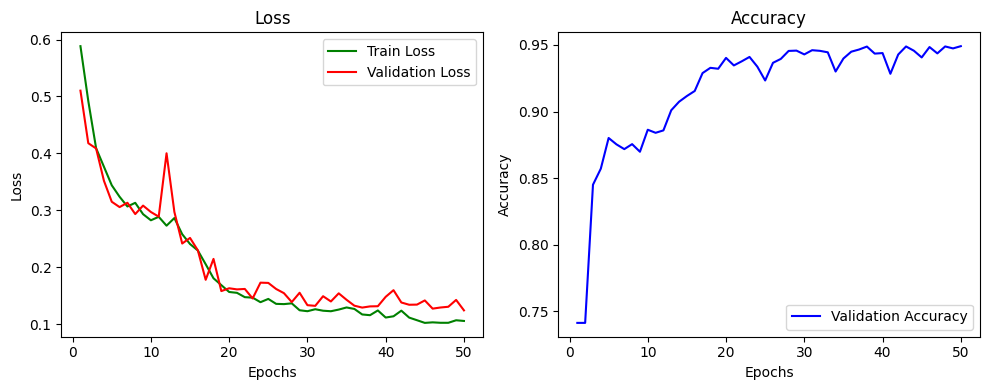

In [40]:
plot_loss_accuracy(train_loss_lst, valid_loss_lst, valid_acc_lst)

In [41]:
model.eval()

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [43]:
create_directory_structure("/kaggle/working/unetmodel")
torch.save(model.state_dict(), '/kaggle/working/unetmodel/segmentation_model.pth')

In [44]:
test_dataset = LesionSegmentationDataset(test_image_paths, test_gt_paths, transform = val_transform)
test_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=False)
sensetivity, specificity, accuracy, jaccard, dice = check_metrics(test_dataloader, model, device="cuda")

Sensitivity: 0.877931
Specificity: nan
Pixel Accuracy: 0.944005
Jaccard Score: 0.809924
Dice Score: 0.884244


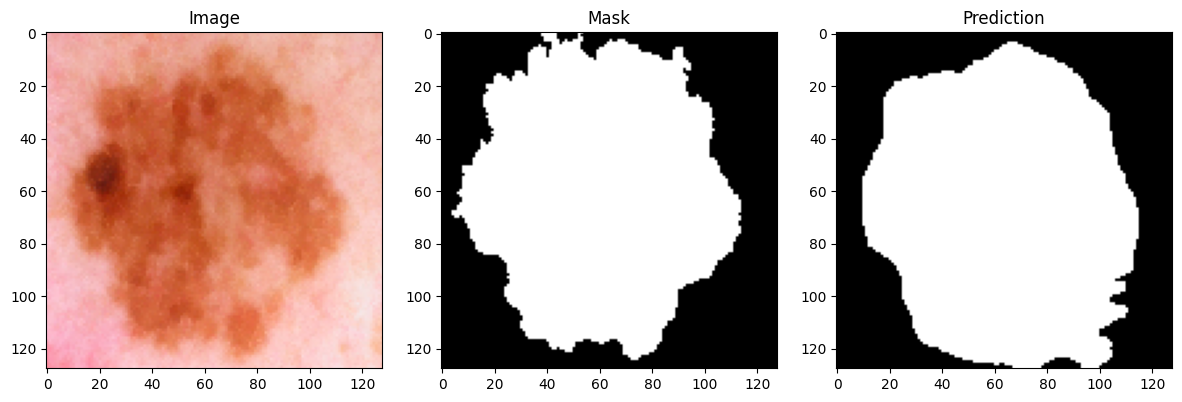

In [45]:
plot_img_mask_pred(test_dataset, plot_pred=True, model=model, device = "cuda")

In [ ]:
unet_model = UNet(enc_chs=(3,32, 64,128,256), dec_chs=(256, 128, 64, 32), num_class=1)
model_path = '/kaggle/working/unetmodel/segmentation_model.pth'
unet_model.load_state_dict(torch.load(model_path,  map_location=torch.device('cpu')))
unet_model.eval()
unet_model.to(device)